In [1]:
import PyPlot
using NearestNeighbors
using SplineUtils

In [2]:
R(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]

R (generic function with 1 method)

# Build Road Networks from Intersections

In [66]:
type Intersection
    id
    x
    y
    θ₁
    θ₂
    connection_N # ID of intersection connected to the North of this one
    connection_E # ID of intersection connected to the East of this one
    connection_S # ID of intersection connected to the South of this one
    connection_W # ID of intersection connected to the West of this one
    
    entrances # Dict(:North, :East, :South, :West) => Dict(-1, 0, 1, ..., offset) => ID(s) of associated lanes
    exits # Dict(:North, :East, :South, :West) => Dict(-1, 0, 1, ..., offset) => ID(s) of associated lanes
    refpoints # Dict(:North, :East, :South, :West) => Dict(:in,:out) => [x;y]
    lanes # Dict(:North, :East, :South, :West) => (x, y)
    
    function Intersection(id,x,y,θ₁,θ₂)
        retval = new()
        retval.id = id
        retval.x = x
        retval.y = y
        retval.θ₁ = θ₁
        retval.θ₂ = θ₂
        retval.connection_N = -1
        retval.connection_E = -1
        retval.connection_S = -1
        retval.connection_W = -1
        retval.entrances = Dict(
            :North => Dict(),
            :South => Dict(),
            :East => Dict(),
            :West => Dict()
        )
        retval.exits = Dict(
            :North => Dict(),
            :South => Dict(),
            :East => Dict(),
            :West => Dict()
        )
        retval.refpoints = Dict(
            :North => Dict(),
            :South => Dict(),
            :East => Dict(),
            :West => Dict()
        )
        retval.lanes = Dict(
            :North => [],
            :South => [],
            :East => [],
            :West => []
        )
        return retval
    end
end

In [4]:
type id_dispenser
    available_ids
    function id_dispenser(num_ids)
        retval = new()
        retval.available_ids = Set(i for i in 1:num_ids)
        return retval
    end
end

In [5]:
function getId(dispenser::id_dispenser)
    return pop!(dispenser.available_ids)
end

getId (generic function with 1 method)

In [6]:
dispenser = id_dispenser(100)

id_dispenser(Set([68, 2, 89, 11, 39, 46, 85, 25, 55, 42  …  72, 28, 5, 23, 63, 27, 56, 97, 41, 15]))

In [7]:
intersections = Dict()
block_array = Dict()
for i in 0:5
    for j in 0:5
        id = getId(dispenser)
        block_array[(i,j)] = id
        θ₁ = rand() / 4
        θ₂ = θ₁ + π/2
        x = i*10.0 + rand()
        y = j*10.0 + rand()
        intersections[id] = Intersection(id, x, y, θ₁, θ₂)
    end
end
for i in 1:4
    for j in 1:4
        id = block_array[(i,j)]
        intersections[id].connection_N = block_array[(i,j+1)]
        intersections[id].connection_E = block_array[(i+1,j)]
        intersections[id].connection_S = block_array[(i,j-1)]
        intersections[id].connection_W = block_array[(i-1,j)]
    end
end

In [121]:
function generateSpline(pt₁, pt₂, θ₁, θ₂; degree=3)
    """
    generates a spline that leaves pt1 at heading θ₁, and arrives
    at pt2 with heading θ₂
    """
    d = norm(pt₁-pt₂)
    V₁ = (d/4) * R(θ₁) * [
        0.0 1.0;
        0.0 0.0
    ] .+ pt₁
    V₂ = (d/4) * R(θ₂+π) * [
        1.0 0.0;
        0.0 0.0
    ] .+ pt₂
    Pts = hcat(V₁,(V₁[:,end]+V₂[:,1])/2,V₂)
    L_tt = 100
    T, tt, x, y = B_Spline(Pts, degree, L_tt)
    return T, tt, x, y
end

generateSpline (generic function with 1 method)

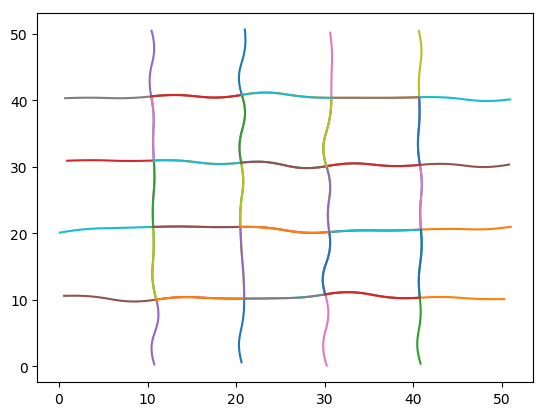

In [124]:
for (id,I) in intersections
    if I.connection_N > -1
        I₂ = intersections[I.connection_N]
        T, tt, x, y = generateSpline([I.x, I.y], [I₂.x, I₂.y], I.θ₂, I₂.θ₂)
        PyPlot.plot(x,y) # plot generated spline roadway
    end
    if I.connection_E > -1
        I₂ = intersections[I.connection_E]
        T, tt, x, y = generateSpline([I.x, I.y], [I₂.x, I₂.y], I.θ₁, I₂.θ₁)
        PyPlot.plot(x,y) # plot generated spline roadway
    end
    if I.connection_S > -1
        I₂ = intersections[I.connection_S]
        T, tt, x, y = generateSpline([I.x, I.y], [I₂.x, I₂.y], I.θ₂+π, I₂.θ₂+π)
        PyPlot.plot(x,y) # plot generated spline roadway
    end
    if I.connection_W > -1
        I₂ = intersections[I.connection_W]
        T, tt, x, y = generateSpline([I.x, I.y], [I₂.x, I₂.y], I.θ₁+π, I₂.θ₁+π)
        PyPlot.plot(x,y) # plot generated spline roadway
    end
end

# Construct Intersection from list of incoming lanes and transitions

In [83]:
function populateIntersection!(intersection,NorthLanesIn,EastLanesIn,SouthLanesIn,WestLanesIn;w=1,b=1)
    
#     intersection = Intersection(id,x,y,θ₁,θ₂)
    x₀ = intersection.x
    y₀ = intersection.y
    θ₁ = intersection.θ₁
    θ₂ = intersection.θ₂
    
    NorthLanesOut = [Set([:Straight]) for i in 1:max(
                        length([lane for lane in NorthLanesIn if :Straight in lane]),
                        length([lane for lane in EastLanesIn if :Left in lane]),
                        length([lane for lane in WestLanesIn if :Right in lane]),)]
    EastLanesOut = [Set([:Straight]) for i in 1:max(
                            length([lane for lane in EastLanesIn if :Straight in lane]),
                            length([lane for lane in SouthLanesIn if :Left in lane]),
                            length([lane for lane in NorthLanesIn if :Right in lane]),)]
    SouthLanesOut = [Set([:Straight]) for i in 1:max(
                            length([lane for lane in SouthLanesIn if :Straight in lane]),
                            length([lane for lane in WestLanesIn if :Left in lane]),
                            length([lane for lane in EastLanesIn if :Right in lane]),)]
    WestLanesOut = [Set([:Straight]) for i in 1:max(
                            length([lane for lane in WestLanesIn if :Straight in lane]),
                            length([lane for lane in NorthLanesIn if :Left in lane]),
                            length([lane for lane in SouthLanesIn if :Right in lane]),)]
    D_NS = max(length(NorthLanesIn) + length(SouthLanesOut), length(SouthLanesIn) + length(NorthLanesOut))
    D_EW = max(length(EastLanesIn) + length(WestLanesOut), length(WestLanesIn) + length(EastLanesOut));
    # incoming lanes - lateral position begins from the right side
    NorthLanePositions_In = [i for i in 1:length(NorthLanesIn)]
    EastLanePositions_In = [i for i in 1:length(EastLanesIn)]
    SouthLanePositions_In = [i for i in 1:length(WestLanesIn)]
    WestLanePositions_In = [i for i in 1:length(SouthLanesIn)]
    # reference positions - for specifying incoming roadway geometry
    NorthPositionRef = 0 + sum([1 for lane in NorthLanesIn if :Straight in lane || :Right in lane])
    EastPositionRef = 0 + sum([1 for lane in EastLanesIn if :Straight in lane || :Right in lane])
    SouthPositionRef = 0 + sum([1 for lane in SouthLanesIn if :Straight in lane || :Right in lane])
    WestPositionRef = 0 + sum([1 for lane in WestLanesIn if :Straight in lane || :Right in lane])
    # outgoing lanes - lateral position counts down from left side (leftover positions are empty--no lanes in them)
    NorthLanePositions_Out = [D_NS + 1 - i for i in 1:length(NorthLanesOut)]
    EastLanePositions_Out = [D_EW + 1 - i for i in 1:length(EastLanesOut)]
    SouthLanePositions_Out = [D_NS + 1 - i for i in 1:length(SouthLanesOut)]
    WestLanePositions_Out = [D_EW + 1 - i for i in 1:length(WestLanesOut)]
    
    dN = w*D_NS/2 + b # width of North-bound road section
    dS = w*D_NS/2 + b # width of South-bound road section
    dE = w*D_EW/2 + b # width of East-bound road section
    dW = w*D_EW/2 + b # width of West-bound road section
    south_vec = - dW * R(θ₂) * [1; 0]
    north_vec = + dE * R(θ₂) * [1; 0]
    east_vec = + dS * R(θ₁) * [1; 0]
    west_vec = - dN * R(θ₁) * [1; 0]
    south_ctr = south_vec + [x₀;y₀]
    north_ctr = north_vec + [x₀;y₀]
    east_ctr = east_vec + [x₀;y₀]
    west_ctr = west_vec + [x₀;y₀]

    SE_corner = [x₀;y₀] + south_vec + east_vec
    NE_corner = [x₀;y₀] + east_vec + north_vec
    NW_corner = [x₀;y₀] + north_vec + west_vec
    SW_corner = [x₀;y₀] + west_vec + south_vec

    # entry points
    NorthEntryPoints = [(SE_corner .+ normalize(west_vec)*(w*(p-.5) + b)) for p in NorthLanePositions_In]
    EastEntryPoints = [(SW_corner .+ normalize(north_vec)*(w*(p-.5) + b)) for p in EastLanePositions_In]
    SouthEntryPoints = [(NW_corner .+ normalize(east_vec)*(w*(p-.5) + b)) for p in SouthLanePositions_In]
    WestEntryPoints = [(NE_corner .+ normalize(south_vec)*(w*(p-.5) + b)) for p in WestLanePositions_In]
    entrances = vcat(NorthEntryPoints, EastEntryPoints, WestEntryPoints, SouthEntryPoints)
    # reference points in
    NorthRefPtIn = NorthEntryPoints[NorthPositionRef] .+ normalize(west_vec)*w*(.5)
    EastRefPtIn = EastEntryPoints[EastPositionRef] .+ normalize(north_vec)*w*(.5)
    SouthRefPtIn = SouthEntryPoints[SouthPositionRef] .+ normalize(east_vec)*w*(.5)
    WestRefPtIn = WestEntryPoints[WestPositionRef] .+ normalize(south_vec)*w*(.5) 
    refs = [NorthRefPtIn, EastRefPtIn, SouthRefPtIn, WestRefPtIn]
    # exit points
    NorthExitPoints = [(NW_corner .+ normalize(east_vec)*(w*(p-.5) + b)) for p in NorthLanePositions_Out]
    EastExitPoints = [(NE_corner .+ normalize(south_vec)*(w*(p-.5) + b)) for p in EastLanePositions_Out]
    SouthExitPoints = [(SE_corner .+ normalize(west_vec)*(w*(p-.5) + b)) for p in SouthLanePositions_Out]
    WestExitPoints = [(SW_corner .+ normalize(north_vec)*(w*(p-.5) + b)) for p in WestLanePositions_Out]
    exits = vcat(NorthExitPoints, EastExitPoints, WestExitPoints, SouthExitPoints)
    # reference points out
    NorthRefPtOut = NorthExitPoints[end] .+ normalize(west_vec)*w*(.5)
    EastRefPtOut = EastExitPoints[end] .+ normalize(north_vec)*w*(.5)
    SouthRefPtOut = SouthExitPoints[end] .+ normalize(east_vec)*w*(.5)
    WestRefPtOut = WestExitPoints[end] .+ normalize(south_vec)*w*(.5)
    refs_out = [NorthRefPtOut, EastRefPtOut, SouthRefPtOut, WestRefPtOut]
    
    LanesIn = [NorthLanesIn, EastLanesIn, SouthLanesIn, WestLanesIn]
    CenterEntryPoints = [NorthEntryPoints, EastEntryPoints, SouthEntryPoints, WestEntryPoints]
    CenterExitPoints = [NorthExitPoints, EastExitPoints, SouthExitPoints, WestExitPoints]
    LeftExitPoints = [WestExitPoints, NorthExitPoints, EastExitPoints, SouthExitPoints]
    RightExitPoints = [EastExitPoints, SouthExitPoints, WestExitPoints, NorthExitPoints]
    LeftCrnrs = [SW_corner, NW_corner, NE_corner, SE_corner]
    RightCrnrs = [SE_corner, SW_corner, NW_corner, NE_corner]
    colors = ["cyan", "orange", "lime", "red"]
    directions = [:North, :East, :West, :South]
    intersection.refpoints[:North][:in] = NorthRefPtIn
    intersection.refpoints[:North][:out] = NorthRefPtOut
    intersection.refpoints[:South][:in] = SouthRefPtIn
    intersection.refpoints[:South][:out] = SouthRefPtOut
    intersection.refpoints[:East][:in] = EastRefPtIn
    intersection.refpoints[:East][:out] = EastRefPtOut
    intersection.refpoints[:West][:in] = WestRefPtIn
    intersection.refpoints[:West][:out] = WestRefPtOut
    
    for (j,direction) in enumerate(directions)
        for (i,lane) in enumerate(reverse(LanesIn[j]))
            if :Straight in lane
                pt₁ = CenterEntryPoints[j][i]
                pt₂ = CenterExitPoints[j][i]
                x = collect(linspace(pt₁[1],pt₂[1]))
                y = collect(linspace(pt₁[2],pt₂[2]))
                push!(intersection.lanes[direction], (x,y))
#                 PyPlot.plot(x,y,c=colors[j])
            end
            if :Right in lane
                x = []
                y = []
                # plot arc 
                pt₁ = CenterEntryPoints[j][i]
                pt₂ = RightExitPoints[j][i]
                ctr = RightCrnrs[j]
                Δ₁ = pt₁ - ctr
                Δ₂ = pt₂ - ctr
                if norm(Δ₂) - norm(Δ₁) > 0.01
                    append!(x,pt₁[1])
                    append!(y,pt₁[2])
                    pt₁ = pt₁ .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
                    ctr = ctr .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
                    Δ₁ = pt₁ - ctr
                    r = norm(Δ₁) #* sin(θ₂-θ₁)
                    ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                    ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                    ϕ = collect(linspace(ϕ₂,ϕ₂+mod(ϕ₁-ϕ₂,2*π)))
                    x = vcat(x, r*cos.(ϕ) + ctr[1])
                    y = vcat(y, r*sin.(ϕ) + ctr[2])
                elseif norm(Δ₁) - norm(Δ₂) > 0.01
                    append!(x,pt₂[1])
                    append!(y,pt₂[2])
                    pt₂ = pt₂ .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
                    ctr = ctr .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
                    Δ₂ = pt₂ - ctr
                    r = norm(Δ₁) #* sin(θ₂-θ₁)
                    ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                    ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                    ϕ = collect(linspace(ϕ₂,ϕ₂+mod(ϕ₁-ϕ₂,2*π)))
                    x = vcat(r*cos.(ϕ) + ctr[1], x)
                    y = vcat(r*sin.(ϕ) + ctr[2], y)
                else
                    r = norm(Δ₁) #* sin(θ₂-θ₁)
                    ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                    ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                    ϕ = collect(linspace(ϕ₂,ϕ₂+mod(ϕ₁-ϕ₂,2*π)))
                    x = r*cos.(ϕ) + ctr[1]
                    y = r*sin.(ϕ) + ctr[2]
                end
                push!(intersection.lanes[direction], (x,y))
#                 PyPlot.plot(x,y,c=colors[j])
            end
        end
        for (i,lane) in enumerate(LanesIn[j])
            if :Left in lane
                x = []
                y = []
                pt₁ = reverse(CenterEntryPoints[j])[i]
                pt₂ = reverse(LeftExitPoints[j])[i]
                ctr = LeftCrnrs[j]
                Δ₁ = pt₁ - ctr
                Δ₂ = pt₂ - ctr
                if norm(Δ₂) - norm(Δ₁) > 0.01
                    append!(x,pt₁[1])
                    append!(y,pt₁[2])
                    pt₁ = pt₁ .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
                    ctr = ctr .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
                    Δ₁ = pt₁ - ctr
                    r = norm(Δ₁) #* sin(θ₂-θ₁)
                    ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                    ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                    ϕ = collect(linspace(ϕ₁,ϕ₁+mod(ϕ₂-ϕ₁,2*π)))
                    x = vcat(x, r*cos.(ϕ) + ctr[1])
                    y = vcat(y, r*sin.(ϕ) + ctr[2])
                elseif norm(Δ₁) - norm(Δ₂) > 0.01
                    append!(x,pt₂[1])
                    append!(y,pt₂[2])
                    pt₂ = pt₂ .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
                    ctr = ctr .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
                    Δ₂ = pt₂ - ctr
                    r = norm(Δ₁) #* sin(θ₂-θ₁)
                    ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                    ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                    ϕ = collect(linspace(ϕ₁,ϕ₁+mod(ϕ₂-ϕ₁,2*π)))
                    x = vcat(r*cos.(ϕ) + ctr[1], x)
                    y = vcat(r*sin.(ϕ) + ctr[2], y)
                else
                    r = norm(Δ₁) #* sin(θ₂-θ₁)
                    ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                    ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                    ϕ = collect(linspace(ϕ₁,ϕ₁+mod(ϕ₂-ϕ₁,2*π)))
                    x = r*cos.(ϕ) + ctr[1]
                    y = r*sin.(ϕ) + ctr[2]
                end
                push!(intersection.lanes[direction], (x,y))
#                 PyPlot.plot(x,y,c=colors[j])
            end
        end
    end
end

populateIntersection! (generic function with 1 method)

In [84]:
# transitions by incoming lanes - lanes listed left to right
NorthLanesIn = [Set([:Left]), Set([:Left]), Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])]
EastLanesIn = [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])]
SouthLanesIn = [Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])]
WestLanesIn = [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])];
id = 0
x = 0
y = 0
θ₁ = -π/6
θ₂ = θ₁+π/2
I1 = Intersection(id,x,y,θ₁,θ₂);

In [117]:
NorthLanesIn = [Set([:Left]), Set([:Left]), Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])]
EastLanesIn = [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])]
SouthLanesIn = [Set([:Left,:Straight]), Set([:Straight]), Set([:Straight,:Right])]
WestLanesIn = [Set([:Left]), Set([:Straight]), Set([:Straight]), Set([:Straight,:Right])];
id = 1
θ₁ = π/6
θ₂ = θ₁+π/2
I2 = Intersection(id,33,2,θ₁,θ₂);

In [118]:
populateIntersection!(I1,NorthLanesIn,EastLanesIn,SouthLanesIn,WestLanesIn)
populateIntersection!(I2,NorthLanesIn,EastLanesIn,SouthLanesIn,WestLanesIn)

In [136]:
T,tt,xa,ya = generateSpline(I1.refpoints[:East][:out], I2.refpoints[:East][:in], I1.θ₁, I2.θ₁; degree=3);
T,tt,xb,yb = generateSpline(I2.refpoints[:West][:out], I1.refpoints[:West][:in], I2.θ₁+π, I1.θ₁+π; degree=3);
T,tt,xc,yc = generateSpline(I2.refpoints[:North][:out], I1.refpoints[:South][:in], I2.θ₂, I1.θ₂+π; degree=3);
T,tt,xd,yd = generateSpline(I1.refpoints[:North][:out], I2.refpoints[:South][:in], I1.θ₂, I2.θ₂+π; degree=3);

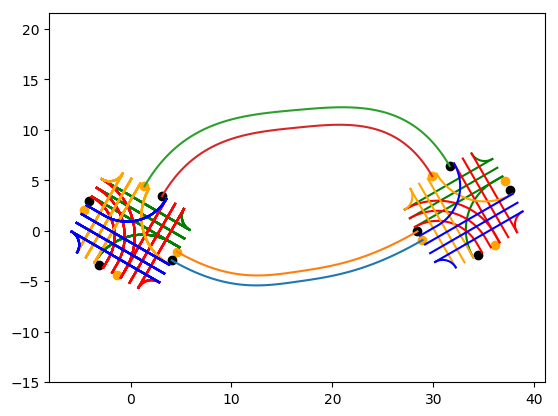

(-8.063139720814412, 41.06313972081441, -6.540606694887513, 13.116225617978346)

In [137]:
colors = Dict(
    :North => "red",
    :East => "blue",
    :South => "green",
    :West => "orange",
)
for (direction, lanes) in I1.lanes
    for lane in lanes
        PyPlot.plot(lane[1],lane[2],c=colors[direction])
    end
end
for (direction, refs) in I1.refpoints
    PyPlot.scatter(refs[:in][1],refs[:in][2],c="orange")
    PyPlot.scatter(refs[:out][1],refs[:out][2],c="black")
end
for (direction, lanes) in I2.lanes
    for lane in lanes
        PyPlot.plot(lane[1],lane[2],c=colors[direction])
    end
end
for (direction, refs) in I2.refpoints
    PyPlot.scatter(refs[:in][1],refs[:in][2],c="orange")
    PyPlot.scatter(refs[:out][1],refs[:out][2],c="black")
end
PyPlot.plot(xa,ya)
PyPlot.plot(xb,yb)
PyPlot.plot(xc,yc)
PyPlot.plot(xd,yd)
PyPlot.axis("equal")

In [ ]:
# transitions by outgoing lanes - lanes listed left to right
NorthLanesOut = [Set([:Straight]) for i in 1:max(
                        length([lane for lane in NorthLanesIn if :Straight in lane]),
                        length([lane for lane in EastLanesIn if :Left in lane]),
                        length([lane for lane in WestLanesIn if :Right in lane]),)]
EastLanesOut = [Set([:Straight]) for i in 1:max(
                        length([lane for lane in EastLanesIn if :Straight in lane]),
                        length([lane for lane in SouthLanesIn if :Left in lane]),
                        length([lane for lane in NorthLanesIn if :Right in lane]),)]
SouthLanesOut = [Set([:Straight]) for i in 1:max(
                        length([lane for lane in SouthLanesIn if :Straight in lane]),
                        length([lane for lane in WestLanesIn if :Left in lane]),
                        length([lane for lane in EastLanesIn if :Right in lane]),)]
WestLanesOut = [Set([:Straight]) for i in 1:max(
                        length([lane for lane in WestLanesIn if :Straight in lane]),
                        length([lane for lane in NorthLanesIn if :Left in lane]),
                        length([lane for lane in SouthLanesIn if :Right in lane]),)]
D_NS = max(length(NorthLanesIn) + length(SouthLanesOut), length(SouthLanesIn) + length(NorthLanesOut))
D_EW = max(length(EastLanesIn) + length(WestLanesOut), length(WestLanesIn) + length(EastLanesOut));
# incoming lanes - lateral position begins from the right side
NorthLanePositions_In = [i for i in 1:length(NorthLanesIn)]
EastLanePositions_In = [i for i in 1:length(EastLanesIn)]
SouthLanePositions_In = [i for i in 1:length(WestLanesIn)]
WestLanePositions_In = [i for i in 1:length(SouthLanesIn)]
# reference positions - for specifying incoming roadway geometry
NorthPositionRef = 0 + sum([1 for lane in NorthLanesIn if :Straight in lane || :Right in lane])
EastPositionRef = 0 + sum([1 for lane in EastLanesIn if :Straight in lane || :Right in lane])
SouthPositionRef = 0 + sum([1 for lane in SouthLanesIn if :Straight in lane || :Right in lane])
WestPositionRef = 0 + sum([1 for lane in WestLanesIn if :Straight in lane || :Right in lane])
# outgoing lanes - lateral position counts down from left side (leftover positions are empty--no lanes in them)
NorthLanePositions_Out = [D_NS + 1 - i for i in 1:length(NorthLanesOut)]
EastLanePositions_Out = [D_EW + 1 - i for i in 1:length(EastLanesOut)]
SouthLanePositions_Out = [D_NS + 1 - i for i in 1:length(SouthLanesOut)]
WestLanePositions_Out = [D_EW + 1 - i for i in 1:length(WestLanesOut)]

w = 1
b = 1.5 # buffer distance to make intersection less tight
ctr = [0;0]
θ₁ = π/6 # theta E-W
θ₂ = θ₁ + π/2 # theta N-S
x₁ = 3
y₁ = 2
dN = w*D_NS/2 + b # width of North-bound road section
dS = w*D_NS/2 + b # width of South-bound road section
dE = w*D_EW/2 + b # width of East-bound road section
dW = w*D_EW/2 + b # width of West-bound road section
south_vec = - dW * R(θ₂) * [1; 0]
north_vec = + dE * R(θ₂) * [1; 0]
east_vec = + dS * R(θ₁) * [1; 0]
west_vec = - dN * R(θ₁) * [1; 0]
south_ctr = south_vec + [x₁;y₁]
north_ctr = north_vec + [x₁;y₁]
east_ctr = east_vec + [x₁;y₁]
west_ctr = west_vec + [x₁;y₁]

SE_corner = [x₁;y₁] + south_vec + east_vec
NE_corner = [x₁;y₁] + east_vec + north_vec
NW_corner = [x₁;y₁] + north_vec + west_vec
SW_corner = [x₁;y₁] + west_vec + south_vec

# entry points
NorthEntryPoints = [(SE_corner .+ normalize(west_vec)*(w*(p-.5) + b)) for p in NorthLanePositions_In]
EastEntryPoints = [(SW_corner .+ normalize(north_vec)*(w*(p-.5) + b)) for p in EastLanePositions_In]
SouthEntryPoints = [(NW_corner .+ normalize(east_vec)*(w*(p-.5) + b)) for p in SouthLanePositions_In]
WestEntryPoints = [(NE_corner .+ normalize(south_vec)*(w*(p-.5) + b)) for p in WestLanePositions_In]
entrances = vcat(NorthEntryPoints, EastEntryPoints, WestEntryPoints, SouthEntryPoints)
# reference points in
NorthRefPtIn = NorthEntryPoints[NorthPositionRef] .+ normalize(west_vec)*w*(.5)
EastRefPtIn = EastEntryPoints[EastPositionRef] .+ normalize(north_vec)*w*(.5)
SouthRefPtIn = SouthEntryPoints[SouthPositionRef] .+ normalize(east_vec)*w*(.5)
WestRefPtIn = WestEntryPoints[WestPositionRef] .+ normalize(south_vec)*w*(.5) 
refs = [NorthRefPtIn, EastRefPtIn, SouthRefPtIn, WestRefPtIn]
# exit points
NorthExitPoints = [(NW_corner .+ normalize(east_vec)*(w*(p-.5) + b)) for p in NorthLanePositions_Out]
EastExitPoints = [(NE_corner .+ normalize(south_vec)*(w*(p-.5) + b)) for p in EastLanePositions_Out]
SouthExitPoints = [(SE_corner .+ normalize(west_vec)*(w*(p-.5) + b)) for p in SouthLanePositions_Out]
WestExitPoints = [(SW_corner .+ normalize(north_vec)*(w*(p-.5) + b)) for p in WestLanePositions_Out]
exits = vcat(NorthExitPoints, EastExitPoints, WestExitPoints, SouthExitPoints)
# reference points out
NorthRefPtOut = NorthExitPoints[end] .+ normalize(west_vec)*w*(.5)
EastRefPtOut = EastExitPoints[end] .+ normalize(north_vec)*w*(.5)
SouthRefPtOut = SouthExitPoints[end] .+ normalize(east_vec)*w*(.5)
WestRefPtOut = WestExitPoints[end] .+ normalize(south_vec)*w*(.5)
refs_out = [NorthRefPtOut, EastRefPtOut, SouthRefPtOut, WestRefPtOut]

PyPlot.scatter(
    [north_ctr[1] east_ctr[1] south_ctr[1] west_ctr[1]],
    [north_ctr[2] east_ctr[2] south_ctr[2] west_ctr[2]], label="center pts")
PyPlot.scatter(
    [SE_corner[1] NE_corner[1] NW_corner[1] SW_corner[1]],
    [SE_corner[2] NE_corner[2] NW_corner[2] SW_corner[2]], label="corner pts")
PyPlot.scatter(
    [entrance[1] for entrance in entrances],
    [entrance[2] for entrance in entrances], label="entrance pts")
PyPlot.scatter(
    [ref[1] for ref in refs],
    [ref[2] for ref in refs],c="black", label="reference pts")
PyPlot.scatter(
    [ref[1] for ref in refs_out],
    [ref[2] for ref in refs_out],c="black", label="reference pts")
PyPlot.scatter(
    [exit[1] for exit in exits],
    [exit[2] for exit in exits], label="exit pts")

LanesIn = [NorthLanesIn, EastLanesIn, SouthLanesIn, WestLanesIn]
CenterEntryPoints = [NorthEntryPoints, EastEntryPoints, SouthEntryPoints, WestEntryPoints]
CenterExitPoints = [NorthExitPoints, EastExitPoints, SouthExitPoints, WestExitPoints]
LeftExitPoints = [WestExitPoints, NorthExitPoints, EastExitPoints, SouthExitPoints]
RightExitPoints = [EastExitPoints, SouthExitPoints, WestExitPoints, NorthExitPoints]
LeftCrnrs = [SW_corner, NW_corner, NE_corner, SE_corner]
RightCrnrs = [SE_corner, SW_corner, NW_corner, NE_corner]
colors = ["cyan", "orange", "lime", "red"]

for j in 1:4
    for (i,lane) in enumerate(reverse(LanesIn[j]))
        if :Straight in lane
            pt₁ = CenterEntryPoints[j][i]
            pt₂ = CenterExitPoints[j][i]
            x = collect(linspace(pt₁[1],pt₂[1]))
            y = collect(linspace(pt₁[2],pt₂[2]))
            PyPlot.plot(x,y,c=colors[j])
        end
        if :Right in lane
            x = []
            y = []
            # plot arc 
            pt₁ = CenterEntryPoints[j][i]
            pt₂ = RightExitPoints[j][i]
            ctr = RightCrnrs[j]
            Δ₁ = pt₁ - ctr
            Δ₂ = pt₂ - ctr
            if norm(Δ₂) - norm(Δ₁) > 0.01
                append!(x,pt₁[1])
                append!(y,pt₁[2])
                pt₁ = pt₁ .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
                ctr = ctr .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
                Δ₁ = pt₁ - ctr
                r = norm(Δ₁) #* sin(θ₂-θ₁)
                ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                ϕ = collect(linspace(ϕ₂,ϕ₂+mod(ϕ₁-ϕ₂,2*π)))
                x = vcat(x, r*cos.(ϕ) + ctr[1])
                y = vcat(y, r*sin.(ϕ) + ctr[2])
            elseif norm(Δ₁) - norm(Δ₂) > 0.01
                append!(x,pt₂[1])
                append!(y,pt₂[2])
                pt₂ = pt₂ .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
                ctr = ctr .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
                Δ₂ = pt₂ - ctr
                r = norm(Δ₁) #* sin(θ₂-θ₁)
                ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                ϕ = collect(linspace(ϕ₂,ϕ₂+mod(ϕ₁-ϕ₂,2*π)))
                x = vcat(r*cos.(ϕ) + ctr[1], x)
                y = vcat(r*sin.(ϕ) + ctr[2], y)
            else
                r = norm(Δ₁) #* sin(θ₂-θ₁)
                ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                ϕ = collect(linspace(ϕ₂,ϕ₂+mod(ϕ₁-ϕ₂,2*π)))
                x = r*cos.(ϕ) + ctr[1]
                y = r*sin.(ϕ) + ctr[2]
            end
            PyPlot.plot(x,y,c=colors[j])
        end
    end
    for (i,lane) in enumerate(LanesIn[j])
        if :Left in lane
            x = []
            y = []
            pt₁ = reverse(CenterEntryPoints[j])[i]
            pt₂ = reverse(LeftExitPoints[j])[i]
            ctr = LeftCrnrs[j]
            Δ₁ = pt₁ - ctr
            Δ₂ = pt₂ - ctr
            if norm(Δ₂) - norm(Δ₁) > 0.01
                append!(x,pt₁[1])
                append!(y,pt₁[2])
                pt₁ = pt₁ .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
                ctr = ctr .+ Δ₂*(norm(Δ₂)-norm(Δ₁))/norm(Δ₂)
                Δ₁ = pt₁ - ctr
                r = norm(Δ₁) #* sin(θ₂-θ₁)
                ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                ϕ = collect(linspace(ϕ₁,ϕ₁+mod(ϕ₂-ϕ₁,2*π)))
                x = vcat(x, r*cos.(ϕ) + ctr[1])
                y = vcat(y, r*sin.(ϕ) + ctr[2])
            elseif norm(Δ₁) - norm(Δ₂) > 0.01
                append!(x,pt₂[1])
                append!(y,pt₂[2])
                pt₂ = pt₂ .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
                ctr = ctr .+ Δ₁*(norm(Δ₁)-norm(Δ₂))/norm(Δ₁)
                Δ₂ = pt₂ - ctr
                r = norm(Δ₁) #* sin(θ₂-θ₁)
                ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                ϕ = collect(linspace(ϕ₁,ϕ₁+mod(ϕ₂-ϕ₁,2*π)))
                x = vcat(r*cos.(ϕ) + ctr[1], x)
                y = vcat(r*sin.(ϕ) + ctr[2], y)
            else
                r = norm(Δ₁) #* sin(θ₂-θ₁)
                ϕ₁ = atan2(Δ₁[2],Δ₁[1])
                ϕ₂ = atan2(Δ₂[2],Δ₂[1])
                ϕ = collect(linspace(ϕ₁,ϕ₁+mod(ϕ₂-ϕ₁,2*π)))
                x = r*cos.(ϕ) + ctr[1]
                y = r*sin.(ϕ) + ctr[2]
            end
            PyPlot.plot(x,y,c=colors[j])
        end
    end
end
PyPlot.axis("equal")
# PyPlot.legend()

In [ ]:
Dict(
    :A=>1,
    :B=>2
)

# Generate Connecting Roadway Geometry (between intersections)

# Dubbins stuff

In [ ]:
function Dubbins(x1,y1,θ1,x2,y2,θ2)
    """
    returns points along Dubbins curve from Pt1 to Pt2
    """
    dx = x2 - x1
    dy = y2 - y1
    dth = th2 - th1
    θₕ = atan2(dy,dx)
    
end

In [ ]:
R = 3
x₁ = 0
y₁ = 0
θ₁ = -π/4

x₂ = 5
y₂ = 2
θ₂ = π/3

Δx = x₂ - x₁
Δy = y₂ - y₁
θₕ = atan2(Δy,Δx)
Δθ₁ = θₕ - θ₁
Δθ₂ = θ₂ - θₕ

c₁₊ = [x₁ - R*sin(θ₁), y₁ + R*cos(θ₁)]
c₁₋ = [x₁ + R*sin(θ₁), y₁ - R*cos(θ₁)]
c₂₊ = [x₂ - R*sin(θ₂), y₂ + R*cos(θ₂)]
c₂₋ = [x₂ + R*sin(θ₂), y₂ - R*cos(θ₂)]

D₊₊ = sqrt(sum((c₁₊ .- c₂₊).^2))
D₊₋ = sqrt(sum((c₁₊ .- c₂₋).^2))
D₋₊ = sqrt(sum((c₁₋ .- c₂₊).^2))
D₋₋ = sqrt(sum((c₁₋ .- c₂₋).^2))

if D₊₊ < 4*R
    # options = straight and circle
else
    # option = straight only
end

if D₊₊ < 4*R
    # options = straight and circle
else
    # option = straight only
end



if indmin(D) == 1
    # CCW, S, CCW
elseif indmin(D) == 2
    # CSC
elseif indmin(D) == 3
elseif indmin(D) == 4
    # CW, S, CW
end
# # Dubbins
# if sqrt((x₂-x₁)^2+(y₂-y₁)^2) > 2*R
#     # curve has a straight segment
#     if Δθ₁ > 0
#         xc₁ = x₁ - R*sin(θ₁)
#         yc₁ = y₁ + R*cos(θ₁)
#         if Δθ₂ > 0
#             xc₂ = x₂ - R*sin(θ₂)
#             yc₂ = y₂ + R*cos(θ₂)
#         else
#             xc₂ = x₂ + R*sin(θ₂)
#             yc₂ = y₂ -R*cos(θ₂)
#         end
#     else
#         xc₁ = x₁ + R*sin(θ₁)
#         yc₁ = y₁ - R*cos(θ₁)
#         if Δθ₂ > 0
#             xc₂ = x₂ - R*sin(θ₂)
#             yc₂ = y₂ + R*cos(θ₂)
#         else
#             xc₂ = x₂ + R*sin(θ₂)
#             yc₂ = y₂ -R*cos(θ₂)
#         end
#     end
# end

# v₁ = [xc₂ - xc₁, yc₂ - yc₁]
# D₁ = sqrt(sum(v₁.*v₁))
# D₂ = -R*sign(Δθ₁)+R*sign(Δθ₂)
# D₃ = sqrt(D₁^2 - D₂^2)
# θᵣ = acos(D₂/D₁) + atan2(v₁[2], v₁[1])
# xp₁= xc₁+R*cos(θᵣ)
# yp₁= yc₁+R*sin(θᵣ)
# xp₂= xc₂-R*cos(θᵣ)
# yp₂= yc₂-R*sin(θᵣ)

PyPlot.scatter(x₁,y₁,c="b")
PyPlot.scatter(x₂,y₂,c="r")
PyPlot.scatter(c₁₊[1],c₁₊[2],c="orange")
PyPlot.scatter(c₂₊[1],c₂₊[2],c="orange")
PyPlot.scatter(c₁₋[1],c₁₋[2],c="cyan")
PyPlot.scatter(c₂₋[1],c₂₋[2],c="cyan")
# PyPlot.scatter(xp₁,yp₁,c="cyan")
# PyPlot.scatter(xp₂,yp₂,c="cyan")

# PyPlot.scatter(x₁+R*[-sin(θ₁), sin(θ₁)], y₁+R*[cos(θ₁), -cos(θ₁)],c="orange")
# PyPlot.scatter(x₂+R*[-sin(θ₂), sin(θ₂)], y₂+R*[cos(θ₂), -cos(θ₂)],c="orange")

PyPlot.plot(x₁+[0,cos(θ₁)],y₁+[0,sin(θ₁)],c="b")
PyPlot.plot(x₂+[0,cos(θ₂)],y₂+[0,sin(θ₂)],c="r")
PyPlot.plot([x₁,x₂],[y₁,y₂],"g")
PyPlot.axis("equal")
